In [1]:
import os

from descartes.patch import PolygonPatch
import joblib
import geopandas as gpd
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
d6_bbls = np.load("data/bimg_labels_d6.npy")
d9_bbls = np.load("data/bimg_labels_d9.npy")
pluto = gpd.read_file("data/pluto/MNMapPLUTO.shp")

[]

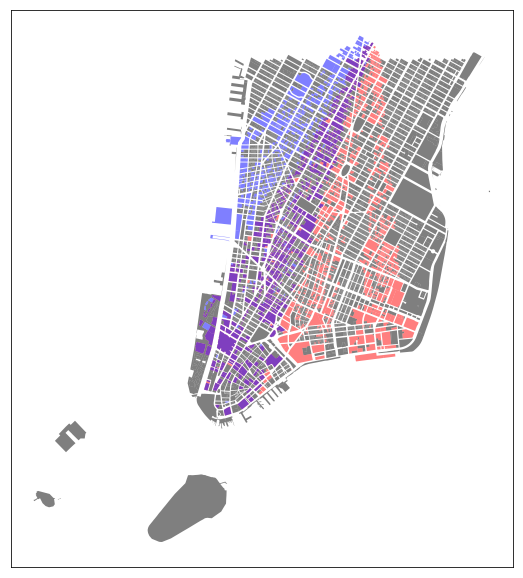

In [5]:
ax = pluto[(pluto.geometry.centroid.y < 213000) &\
           (~pluto.BBL.isin(np.unique(d6_bbls.ravel()))) &\
           (~pluto.BBL.isin(np.unique(d9_bbls.ravel())))].plot(color='black', alpha=.5, figsize=(9, 16))
pluto[pluto.BBL.isin(np.unique(d6_bbls.ravel()))].plot(color='red', alpha=.5, ax=ax)
pluto[pluto.BBL.isin(np.unique(d9_bbls.ravel()))].plot(color='blue', alpha=.5, ax=ax)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
ax.set_yticks([])
ax.set_ylabel("")
ax.set_xticks([])

In [4]:
pluto["surface_area"] = pluto["NumFloors"] * pluto.geometry.length
in_frame = pluto[(pluto.BBL.isin(np.unique(d6_bbls.ravel()))) | pluto.BBL.isin(np.unique(d9_bbls.ravel()))]
out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]

In [5]:
if os.path.exists("data/impute_dists_centroid.gz"):
    dists = joblib.load("data/impute_dists_centroid.gz")
    nearest_idxs = joblib.load("data/impute_idxs_centroid.gz")
else:
    dists = []
    nearest_idxs = []
    for ix, building in out_frame.iterrows():
        if ix % 1000 == 0:
            print("at", ix)
        ds = in_frame.geometry.centroid.distance(building.geometry.centroid)
        dists.append(ds.min())
        nearest_idxs.append(ds.idxmin())
    joblib.dump(dists, "data/impute_dists_centroid.gz", 3)
    joblib.dump(nearest_idxs, "data/impute_idxs_centroid.gz", 3)
dists_arr = np.array(dists)


< 1000: 0.8288671903678144
< 500: 0.7271859628514793
== 0: 0.0


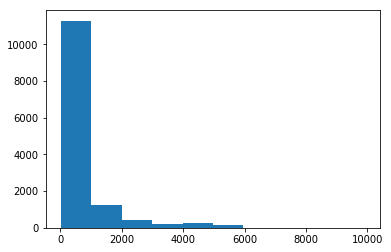

In [6]:
dists_arr = np.array(dists)
plt.hist(dists_arr)
print("< 1000: {}\n< 500: {}\n== 0: {}".format((dists_arr < 1000).sum() / len(dists_arr), 
      (dists_arr < 500).sum() / len(dists_arr),
      (dists_arr == 0).sum() / len(dists_arr)))

Text(0.5,1,'< 1000m')

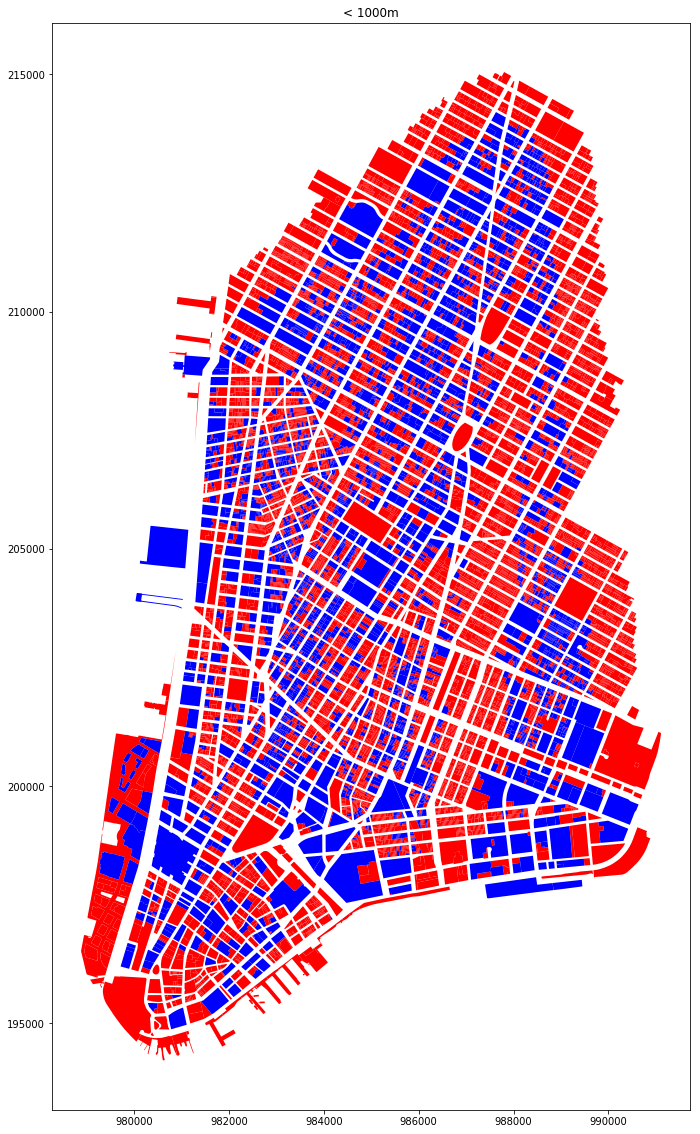

In [7]:
out_reset = out_frame.reset_index()
out_reset["dist"] = np.array(dists_arr)
ax = out_reset[out_reset["dist"] < 1000].plot(figsize=(16, 20), color='red')
in_frame.plot(color='blue', ax=ax)
ax.set_title("< 1000m")

Text(0.5,1,'< 500m')

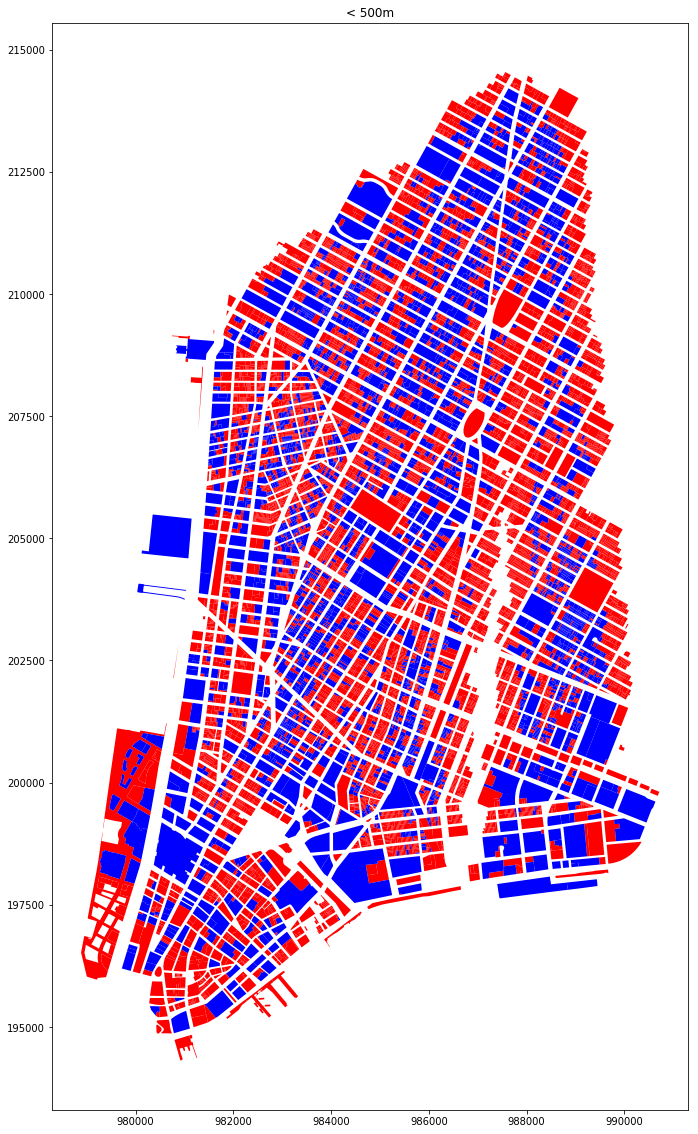

In [8]:
out_reset = out_frame.reset_index()
out_reset["dist"] = np.array(dists_arr)
ax = out_reset[out_reset["dist"] < 500].plot(figsize=(16, 20), color='red')
in_frame.plot(color='blue', ax=ax)
ax.set_title("< 500m")

## Incorporate light levels, 1 night

In [12]:
final_light_d6 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d6_10m.csv")
final_light_d9 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d9_10m.csv")
for df in (final_light_d6, final_light_d9):
    del df["Unnamed: 0"]
    del df["lat"]
    del df["lng"]
final_light_d6 = final_light_d6.set_index("BBL").swapaxes(1, 0)
final_light_d9 = final_light_d9.set_index("BBL").swapaxes(1, 0)
concatd = pd.concat((final_light_d6, final_light_d9))
final_light = concatd.groupby(concatd.index).mean()


In [13]:
nearest_neighbors = [np.abs(in_frame.surface_area - osa).idxmin() for osa in out_frame.surface_area]
out_reset["nearest_ix"] = nearest_neighbors

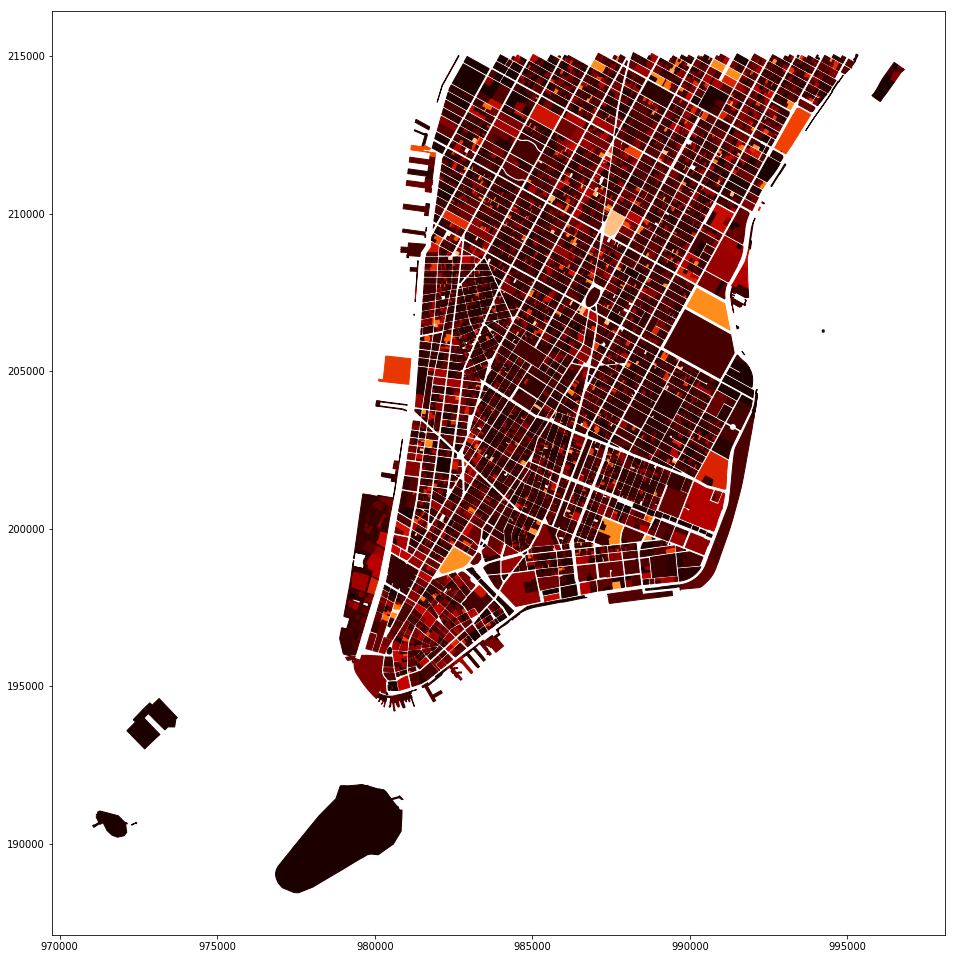

In [21]:

fig, ax = plt.subplots(1, 1, figsize=(16, 20))

polys = []
colors = []
scale = np.log10(final_light_d6.mean()).min()
for _, o_r in out_reset.iterrows():
    cbbl = in_frame.loc[o_r.nearest_ix].BBL
    c = final_light[cbbl].mean()
    polys.append(PolygonPatch(o_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))
for _, i_r in in_frame.iterrows():
    c = final_light[i_r.BBL].mean()
    polys.append(PolygonPatch(i_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))

collection = PatchCollection(polys, color=colors)
ax.add_collection(collection)
ax.autoscale_view()
ax.set_aspect(1)

In [15]:
final_light_d6.max().max(), final_light_d9.max().max()

(1.0, 0.7111561889278477)

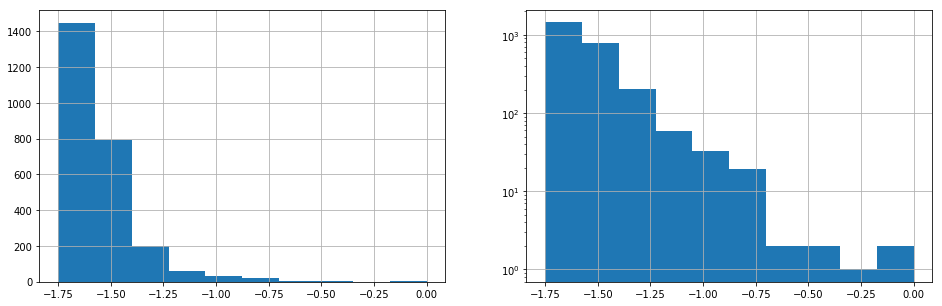

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
np.log10(final_light_d6.mean()).hist(log=True, ax=ax2)
np.log10(final_light_d6.mean()).hist(log=False, ax=ax1)

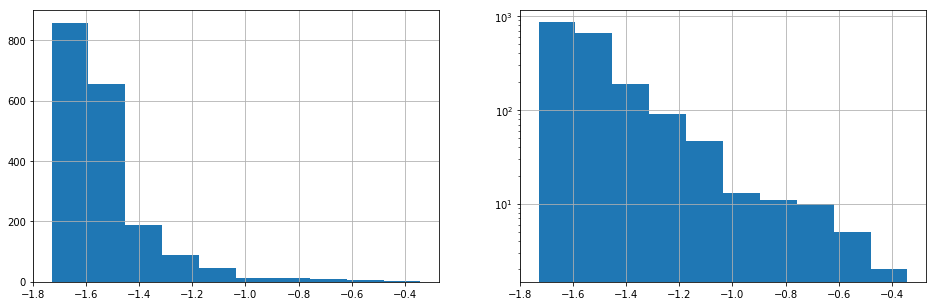

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
np.log10(final_light_d9.mean()).hist(log=True, ax=ax2)
np.log10(final_light_d9.mean()).hist(log=False, ax=ax1)

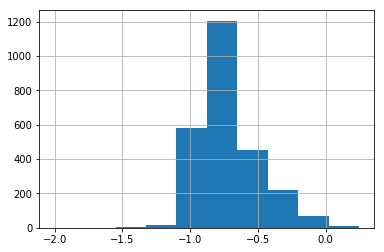

In [18]:
np.log10(np.log10(final_light_d6.mean()) - np.log10(final_light_d6.mean()).min() + .01).hist()

2436     824
33180     48
31789     44
40537     44
302       39
10844     38
28686     38
38611     36
195       36
6108      35
28520     34
11450     34
3167      33
22372     33
7818      33
39264     33
16688     32
40820     32
12662     32
34467     32
6015      31
17581     31
41389     30
22141     30
13161     29
24106     29
23724     29
8382      29
30098     28
8234      27
        ... 
12642      1
39271      1
18805      1
4470       1
10633      1
29066      1
26793      1
14321      1
15582      1
42213      1
9605       1
34286      1
28646      1
7661       1
3424       1
895        1
14339      1
20502      1
40984      1
10281      1
10297      1
11556      1
8312       1
24696      1
3352       1
33679      1
9461       1
31632      1
26785      1
10190      1
Name: nearest_ix, Length: 2657, dtype: int64

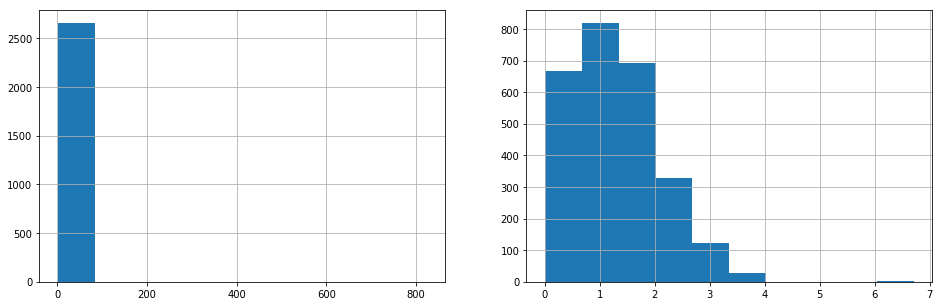

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
out_reset["nearest_ix"].value_counts().hist(ax=ax1)
np.log(out_reset["nearest_ix"].value_counts()).hist(ax=ax2)
out_reset["nearest_ix"].value_counts()

In [24]:
list(pluto.columns)

['Borough',
 'Block',
 'Lot',
 'CD',
 'CT2010',
 'CB2010',
 'SchoolDist',
 'Council',
 'ZipCode',
 'FireComp',
 'PolicePrct',
 'HealthCent',
 'HealthArea',
 'SanitBoro',
 'SanitDistr',
 'SanitSub',
 'Address',
 'ZoneDist1',
 'ZoneDist2',
 'ZoneDist3',
 'ZoneDist4',
 'Overlay1',
 'Overlay2',
 'SPDist1',
 'SPDist2',
 'SPDist3',
 'LtdHeight',
 'SplitZone',
 'BldgClass',
 'LandUse',
 'Easements',
 'OwnerType',
 'OwnerName',
 'LotArea',
 'BldgArea',
 'ComArea',
 'ResArea',
 'OfficeArea',
 'RetailArea',
 'GarageArea',
 'StrgeArea',
 'FactryArea',
 'OtherArea',
 'AreaSource',
 'NumBldgs',
 'NumFloors',
 'UnitsRes',
 'UnitsTotal',
 'LotFront',
 'LotDepth',
 'BldgFront',
 'BldgDepth',
 'Ext',
 'ProxCode',
 'IrrLotCode',
 'LotType',
 'BsmtCode',
 'AssessLand',
 'AssessTot',
 'ExemptLand',
 'ExemptTot',
 'YearBuilt',
 'YearAlter1',
 'YearAlter2',
 'HistDist',
 'Landmark',
 'BuiltFAR',
 'ResidFAR',
 'CommFAR',
 'FacilFAR',
 'BoroCode',
 'BBL',
 'CondoNo',
 'Tract2010',
 'XCoord',
 'YCoord',
 'Zone

In [32]:
# https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?r=18v1
np.sort(in_frame.BldgClass.dropna().str[0].unique())

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z'],
      dtype=object)

In [35]:
pd.options.display.max_columns = None
ind = in_frame.dropna(subset=["BldgClass"])
ind[ind.BldgClass.str.contains("N")]

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,FactryArea,OtherArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_area,SHAPE_len,geometry,surface_area
677,MN,857,75,105,56,1001,02,2,10016,E001,13,15,5700,1,05,1B,4 EAST 28 STREET,C5-2,None,None,None,None,None,None,None,None,None,N,N2,08,0,P,NEW LATHAM HOTEL CORP,7406,69289,3800,65489,0,0,0,0,0,3800,2,1,12.0,0,227,75.00,98.75,75.00,98.75,E,0,N,5,0,1350000.0,7098750.0,0.0,0.0,1904,1906,2014,Madison Square North Historic District,None,9.36,10.00,10.0,10.0,1,1.008570e+09,0,0056,987917,210415,8d,None,104 004,10306,None,0.000000e+00,None,1,None,None,18V1,0,7905.429499,360.043210,"POLYGON ((987976.3380126953 210442.6395874023,...",4320.519713
6871,MN,457,7,103,36.02,2001,01,2,10003,E028,9,14,6500,1,03,3B,317 BOWERY,C6-1,R8B,None,None,None,None,None,None,None,None,Y,N2,08,0,None,"G F ASSOCIATES 1, LP",3050,14910,14910,0,0,0,0,0,0,14910,2,1,6.0,0,1,28.17,165.58,28.00,86.00,None,3,Y,5,2,329400.0,1257750.0,0.0,0.0,1918,1996,0,None,None,4.89,3.44,6.0,6.5,1,1.004570e+09,0,003602,986545,203489,12c,None,102 009,10205,None,0.000000e+00,None,1,None,None,18V1,0,4219.436816,388.373019,"POLYGON ((986572.3526000977 203499.1682128906,...",2330.238281
7631,MN,458,11,103,36.02,2000,01,2,10003,E028,9,14,6500,1,03,3B,6 EAST 3 STREET,R8B,None,None,None,None,None,None,None,None,None,N,N9,08,0,C,DHS,15705,55000,55000,0,0,0,0,0,0,55000,2,1,7.0,0,1,235.00,66.83,134.00,59.00,None,0,Y,5,2,1413000.0,2584800.0,1413000.0,2584800.0,1915,0,0,None,None,3.50,4.00,0.0,4.0,1,1.004580e+09,0,003602,986779,203709,12c,None,102 009,10205,None,0.000000e+00,None,1,None,None,18V1,0,15239.642803,601.064714,"POLYGON ((986900.5814208984 203679.9304199219,...",4207.452963
13191,MN,345,34,103,22.01,1001,01,2,10002,L018,7,14,7600,1,03,2R,190 STANTON STREET,R7A,None,None,None,None,None,None,None,None,None,N,N9,08,0,P,COMMUNITY RECOVERY HO,2500,8710,8710,0,0,0,0,0,0,8710,2,1,5.0,0,12,25.00,100.00,25.00,60.00,E,2,N,5,2,141300.0,968850.0,141300.0,968850.0,1920,1995,0,None,None,3.48,4.00,0.0,4.0,1,1.003450e+09,0,002201,988891,201618,12c,None,102 005,10201,None,0.000000e+00,None,1,None,None,18V1,0,2874.833121,267.858685,"POLYGON ((988923.9822387695 201663.4990234375,...",1339.293890
16008,MN,387,49,103,26.01,2000,01,2,10009,E028,9,14,6700,1,03,3A,271 EAST 4 STREET,R8B,None,None,None,None,None,None,None,None,None,N,N2,08,0,C,DCAS,11900,50478,25378,25100,0,0,0,0,0,25378,2,1,4.0,88,88,123.70,96.20,98.83,65.00,None,0,N,5,0,549000.0,2532600.0,549000.0,2532600.0,1906,1991,0,None,None,4.24,4.00,0.0,4.0,1,1.003870e+09,0,002601,989443,202681,12c,None,102 013,10203,None,1.003870e+09,10/24/1991,1,None,None,18V1,0,11889.519641,439.632343,"POLYGON ((989521.1752319336 202693.6041870117,...",1758.529441
19801,MN,425,8,103,18,5001,01,1,10002,E055,5,14,7400,1,03,2A,197 BOWERY,C6-1,None,None,None,None,None,None,None,None,None,N,N2,08,0,X,COMMON GROUND COMMUNI,3838,24668,24668,0,0,3558,0,0,0,21110,2,1,9.0,0,2,25.00,153.33,25.00,143.33,None,0,Y,5,2,388800.0,2410200.0,388800.0,2410200.0,1900,2003,0,None,None,6.43,3.44,6.0,6.5,1,1.004250e+09,0,0018,986101,201909,12c,None,101N077,10204,None,0.000000e+00,None,1,None,None,18V1,0,3743.859077,352.937979,"POLYGON ((986173.3865966797 201894.6068115234,...",3176.442012
20505,MN,449,25,103,38,7001,01,2,10003,L011,9,14,6500,1,03,4B,72 ST MARKS

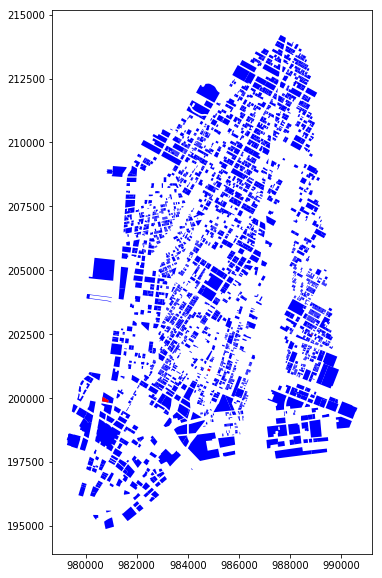

In [39]:
ax = in_frame.plot(color='blue', figsize=(10, 10))
in_frame[in_frame.BldgClass.isnull()].plot(color='red',ax=ax)